In [ ]:
import os

from platform import python_version
import warnings
import time
import datetime as dtw
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/ISEF/dataset2.zip

In [ ]:
epochs = 100
batch_size = 48
testsplit = .2
targetx = 96
targety = 96
learning_rate = 0.0001
classes = 7
seed = 23

datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [ ]:
from keras.preprocessing import image
import numpy as np

def augment_and_save_images(data_dir, save_dir, datagen, num_augmentations=5):
    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            img_path = os.path.join(subdir, file)
            img = image.load_img(img_path, target_size=(targetx, targety))  # Ensure dimensions match your requirements
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Define a saving directory for this image's augmentations
            save_prefix = os.path.join(save_dir, os.path.basename(subdir))
            if not os.path.exists(save_prefix):
                os.makedirs(save_prefix)

            # Create and save augmented images
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_prefix, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= num_augmentations:
                    break  # This creates 'num_augmentations' new images per original image

data_dir = '/content/dataset'  # The directory of your original dataset
save_dir = '/content/augmented_dataset'  # Where to save the augmented images
num_augmentations = 5  # Number of augmented images to create per original image

augment_and_save_images(data_dir, save_dir, datagen, num_augmentations)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    rotation_range=30,  # Rotate images within this range
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zooming
    fill_mode='nearest',
    validation_split=testsplit,
    preprocessing_function=preprocess_input,
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    save_dir,
    target_size=(targetx, targety),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    subset="training"
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    save_dir,
    target_size=(targetx, targety),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=seed,
    subset="validation",
)

Found 3771 images belonging to 7 classes.
Found 939 images belonging to 7 classes.


In [ ]:
checkpoint = ModelCheckpoint('model_isef2.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

In [ ]:
# 변인 통제: DenseNet (Original)

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten() (x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
# Xception

base_model = Xception(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])


83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
# GooLeNet

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [ ]:
%%time


model_history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=len(train_generator),
                                validation_data=val_generator,
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[checkpoint])


Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 3.0232 - accuracy: 0.3288
Epoch 1: val_accuracy improved from -inf to 0.17891, saving model to model_isef2.h5
79/79 [==============================] - 48s 222ms/step - loss: 3.0232 - accuracy: 0.3288 - val_loss: 3.1229 - val_accuracy: 0.1789
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 2.5009 - accuracy: 0.4495
Epoch 2: val_accuracy did not improve from 0.17891
79/79 [==============================] - 15s 195ms/step - loss: 2.5009 - accuracy: 0.4495 - val_loss: 2.9767 - val_accuracy: 0.1374
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 2.0213 - accuracy: 0.6049
Epoch 3: val_accuracy did not improve from 0.17891
79/79 [==============================] - 15s 194ms/step - loss: 2.0213 - accuracy: 0.6049 - val_loss: 3.1166 - val_accuracy: 0.1789
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 1.5645 - accuracy: 0.7160
Epoch 4: val_accuracy did not improve 

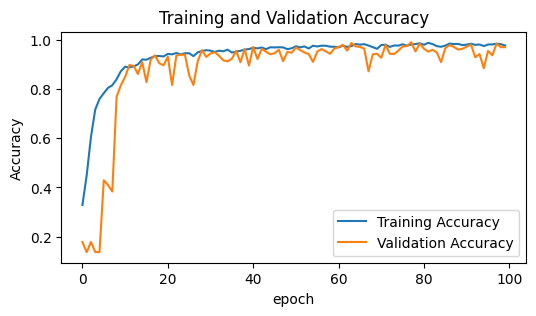

In [ ]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

model = load_model("/content/model_isef2.h5")

In [ ]:
predictions = model.predict_generator(val_generator, steps=len(val_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=val_generator.classes, y_pred=y, target_names=val_generator.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

       anger       0.98      0.99      0.98       130
    contempt       1.00      0.96      0.98        53
     disgust       1.00      0.99      0.99       168
        fear       0.95      0.99      0.97        74
       happy       1.00      1.00      1.00       197
     sadness       0.94      0.99      0.96        82
    surprise       1.00      0.97      0.98       233

    accuracy                           0.99       937
   macro avg       0.98      0.98      0.98       937
weighted avg       0.99      0.99      0.99       937



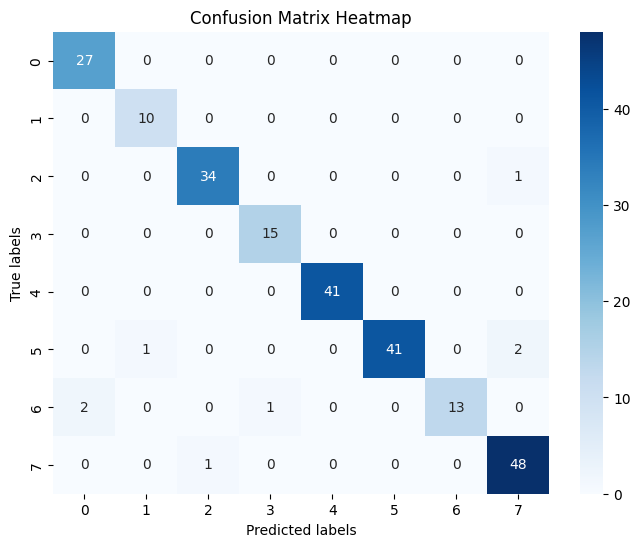

In [ ]:
# Generating the confusion matrix
cm = confusion_matrix(val_generator.classes, y)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()